In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

from numba import njit
from numba_progress import ProgressBar
import scipy.stats as sps
from typing import Callable

In [2]:
from ipywidgets import interact, widgets

## TDMA

In [3]:
# @njit
def progonka(a, b, c, f):
    """
    Метод прогонки
    :param a: диагональ, лежащая под главной (size = n-1)
    :param b: главная диагональ (size = n)
    :param c: диагональ, лежащая над главной (size = n-1)
    :param f: вектор свободных членов (size = n)
    :return: вектор неизвестых y
    """
    n = len(f)
    alpha = np.zeros(n-1)
    beta = np.zeros(n)
    alpha[0] = c[0] / b[0]
    beta[0] = f[0] / b[0]

    # прямая прогонка
    for i in range(1, n-1):
        alpha[i] = c[i] / (b[i] - a[i-1]*alpha[i-1])
        beta[i] = (f[i] - a[i-1]*beta[i-1]) / (b[i] - a[i-1]*alpha[i-1])
    
    beta[n-1] = (f[n-1] - a[-1]*beta[n-2]) / (b[n-1] - a[-1]*alpha[-1])
    
    # обратная прогонка
    y = np.zeros(n)
    y[-1] = beta[-1]
    
    for i in range(n-2, -1, -1):
        y[i] = beta[i] - alpha[i] * y[i+1]
        
    return y

In [4]:
def tridiag(a, b, c):
    """
    Строит матрицу по трем данным диагоналям
    :param a: под главной (size = n-1)
    :param b: главная (size = n)
    :param c: над главной (size = n-1)
    :return: матрица (n x n)
    """
    return np.diag(a, k=-1) + np.diag(b, k=0) + np.diag(c, k=1)

## Варианты граничных и начальных условий

### Lambda

In [14]:
def Lambda_linear(u, coef=5):
    """Штука под правым дифференциалом"""
    return coef * u

In [15]:
def Lambda_random(u, start_value=5):
    
    """return 1d lambda"""
    # n_t, n_x = u.shape
#     Lambda = np.zeros(n_x)
#     Lambda[0] = start_value

#     deltas = sps.norm(loc=0, scale=1).rvs(size=n_x-1, random_state=42)  # распред фиксир (!)
    
#     for i in range(1, n_x):
#         Lambda[i] = Lambda[i-1] + deltas[i-1]
    
    """return 2d lambda"""
    n_t, n_x = u.shape
    Lambda = np.zeros((n_t, n_x))
    Lambda[:, 0] = start_value

    deltas = sps.norm(loc=0, scale=1).rvs(size=n_x-1, random_state=42)  # распред фиксир (!)
    
    for i in range(1, n_x):
        Lambda[:, i] = Lambda[:, i-1] + deltas[i-1]
        
    return Lambda

In [17]:
Lambda = Lambda_random(u)

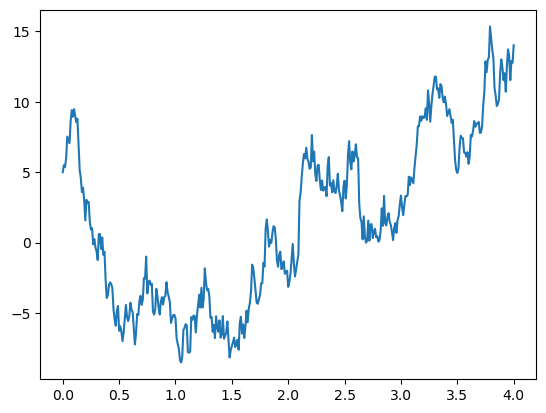

In [18]:
plt.plot(x, Lambda[2])

### Ступенчатая функция

In [19]:
def f_stair(t, delta_t, delta_f=1, start_value=4):
    
    n_t = len(t)
    g = np.zeros(n_t)
    g[0] = start_value
    stride = int(delta_t / tau)
    
    start = 0
    end = start + stride
    value = start_value
    
    for i in range(0, n_t, stride):
        g[start:end] = value
        value += delta_f
        start += stride
        end = start + stride
        
    return g

In [21]:
f = f_stair(t, delta_t=101*tau)
f

array([ 4.,  4.,  4., ..., 13., 13., 13.])

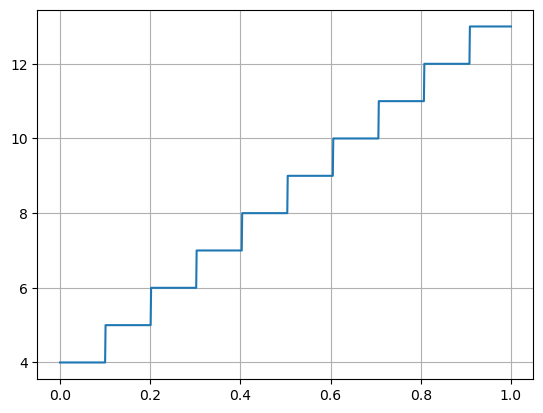

In [22]:
plt.plot(t, f)
plt.grid()

### Q - тепловой поток

**Вариант 1**

$Q(x, t) = 0$ везде

In [23]:
Q = np.zeros((n_t, n_x))

**Вариант 2**

$Q(x_1, t) = const$ в определенной пользователем точке $x_1$

In [24]:
Q = np.zeros((n_t, n_x))

# x1 = np.random.choice(x)
x1 = 0.01
x1_index = np.where(x == x1)[0][0]

x1, x1_index

(0.01, 1)

In [25]:
assert Q[:, x1_index].shape == (n_t,)

In [26]:
Q_value = 6

Q[:, x1_index] = Q_value

In [27]:
Q

array([[0., 6., 0., ..., 0., 0., 0.],
       [0., 6., 0., ..., 0., 0., 0.],
       [0., 6., 0., ..., 0., 0., 0.],
       ...,
       [0., 6., 0., ..., 0., 0., 0.],
       [0., 6., 0., ..., 0., 0., 0.],
       [0., 6., 0., ..., 0., 0., 0.]])

Вариант 3

$Q(x_1, t) = g(t)$   в определенной пользователем точке $x_1$

g(t) - ступенчатая функция

In [28]:
Q = np.zeros((n_t, n_x))

# x1 = np.random.choice(x)
x1 = 0.01
x1_index = np.where(x == x1)[0][0]

x1, x1_index

(0.01, 1)

In [30]:
g = f_stair(t, delta_t=101*tau)  # задаем ступенчатую функцию

Q[:, x1_index] = g

In [31]:
Q

array([[ 0.,  4.,  0., ...,  0.,  0.,  0.],
       [ 0.,  4.,  0., ...,  0.,  0.,  0.],
       [ 0.,  4.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., 13.,  0., ...,  0.,  0.,  0.],
       [ 0., 13.,  0., ...,  0.,  0.,  0.],
       [ 0., 13.,  0., ...,  0.,  0.,  0.]])

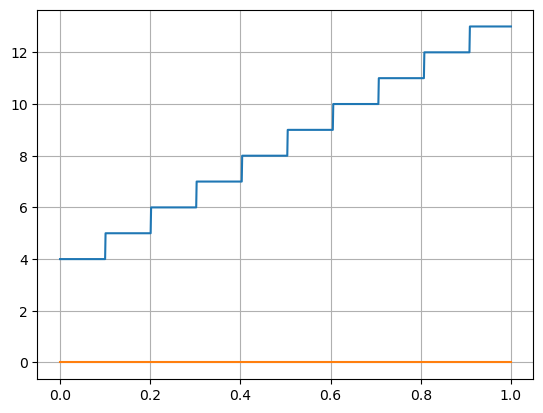

In [32]:
plt.plot(t, Q[:, 1])

plt.plot(t, Q[:, 2])

plt.grid()

### Const func

In [33]:
def const_func(x, const):
    n = len(x)
    return (const * np.ones(n))

In [41]:
type(const_func)

function

## Heat eq starter pack

**grid initialization**

In [162]:
def init_grid(x_max, x_min, t_max, h, tau):
    """
    """
    # assert
    
    n_x = int((x_max - x_min) / h) + 1
    n_t = int(t_max / tau) + 1
    
    x = np.zeros(n_x)
    t = np.zeros(n_t)
    # grid x
    for i in range(len(x)):
        x[i] = i * h
    # grid t
    for i in range(len(t)):
        t[i] = i * tau
    
    u = np.zeros((n_t, n_x))
    
    return u, x, t, n_x, n_t

In [164]:
x_min = 0
x_max = 4
t_max = 1

# implicit
h = 1e-2
tau = 1e-3

# explicit
h = 5e-2
tau = ((h**2 / 2) - 0.03 * (h**2 / 2)) / 10

u, x, t, n_x, n_t = init_grid(x_max, x_min, t_max, h, tau)

**start condition:** $ T(x, 0) $

In [165]:
def start_cond_debug(x):
    """Начальное условие T(x, 0)"""
    return 1 + np.exp((-(x-2)**2) / 0.1)
    # return np.sin(np.pi * x)

In [166]:
# ## 1, 2, 3, 4
# const1 = 2

# start_cond = const_func(x, const1)
# u[0] = start_cond

## debug
start_cond = start_cond_debug(x)
u[0] = start_cond

**left border condition:**  $T(0, t)$

In [167]:
## 1, 3, 4
const2 = 1
left_border_cond = const_func(t, const2)
u[:, 0] = left_border_cond

## 2
# left_border_cond = f_stair(t, delta_t=101*tau, delta_f=1, start_value=4)
# u[:, 0] = left_border_cond
# plt.plot(t, left_border_cond)

**right border condition:** $T(x_{max}, t)$

In [168]:
## 1, 2, 3, 4
const3 = 1

right_border_cond = const_func(t, const3)
u[:, -1] = right_border_cond

**heat flow:** $Q(x, t)$

In [169]:
## 1, 2
Q = np.zeros((n_t, n_x))


# ## 3
# const = 17

# Q = np.zeros((n_t, n_x))
# # x1 = np.random.choice(x)
# x1 = 0.01
# x1_index = np.where(x == x1)[0][0]
# Q[:, x1_index] = const


# ## 4
# g = f_stair(t, delta_t=101*tau)  # задаем ступенчатую функцию

# Q = np.zeros((n_t, n_x))
# # x1 = np.random.choice(x)
# x1 = 0.01
# x1_index = np.where(x == x1)[0][0]
# Q[:, x1_index] = g

**Lambda:** $\lambda(x, t)$

In [170]:
## variant 1
Lambda = Lambda_linear(u, coef=5)
set_Lambda = Lambda_linear

# ## variant 2
# Lambda = Lambda_random(u, start_value=5)
# set_Lambda = Lambda_random

In [171]:
# plt.plot(x, Lambda[10])

In [172]:
u

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

## Implicit scheme

In [173]:
for n in tqdm(range(0, n_t-1)):
    
    A = np.zeros(n_x)
    B = np.zeros(n_x)
    C = np.zeros(n_x)
    F = np.zeros(n_x)
    
    Lambda = set_Lambda(u)  # обязательно пересчитывать Lambda, если она зависит от u !!!!
    
    for i in range(1, n_x-1):
        A[i] = (1/(h**2)) * ((Lambda[n, i] + Lambda[n, i+1]) / 2)
        B[i] = (1/(h**2)) * ((Lambda[n, i] + Lambda[n, i-1]) / 2)
        C[i] = A[i] + B[i] + (1 / tau)
        
        F[i] = Q[n, i] + (u[n, i] / tau)
        
    A = A[1:]  # выкидываем ненужный
    A[-1] = 0  # дополнение граничными условиями
    
    C[0] = 1  # дополнение граничными условиями
    C[-1] = 1  # дополнение граничными условиями
    
    B[0] = 0  # дополнение граничными условиями
    B = B[:-1]  # выкидываем ненужный
    
    F[0] = left_border_cond[n]  # граничные условия слева
    F[-1] = right_border_cond[n]  # граничные условия справа
    
#     Matrix = tridiag(-A, C, -B)
#     u[n+1] = np.linalg.solve(Matrix, F)
    
    u[n+1] = progonka(-A, C, -B, F)

  0%|          | 0/8247 [00:00<?, ?it/s]

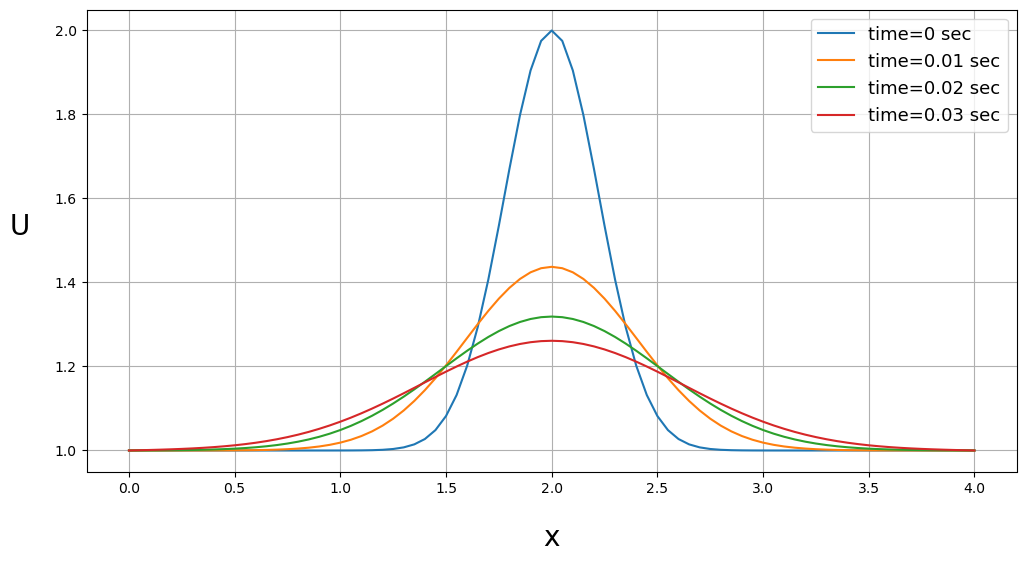

In [159]:
t0, t1, t2, t3 = 0, 0.01, 0.02, 0.03
i0, i1, i2, i3 = int(len(t)*t0), int(len(t)*t1), int(len(t)*t2), int(len(t)*t3)

plt.figure(figsize=(12, 6))
plt.plot(x, u[i0, :], label=f'time={t0} sec')
plt.plot(x, u[i1, :], label=f'time={t1} sec')
plt.plot(x, u[i2, :], label=f'time={t2} sec')
plt.plot(x, u[i3, :], label=f'time={t3} sec')
plt.xlabel('x', fontsize=20, labelpad=20)
plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
plt.legend(fontsize=13)
plt.grid()

## Explicit scheme

In [160]:
for n in tqdm(range(n_t-1)):
    
    Lambda = set_Lambda(u)
    
    for i in range(1, n_x-1):
        A = ((Lambda[n, i] + Lambda[n, i+1]) / 2) * (u[n, i+1] - u[n, i])
        B = ((Lambda[n, i] + Lambda[n, i-1]) / 2) * (u[n, i] - u[n, i-1])
        C = (tau / (h**2)) * (A - B)
                
        u[n+1, i] = u[n, i] + tau * Q[n, i] + C

  0%|          | 0/8247 [00:00<?, ?it/s]

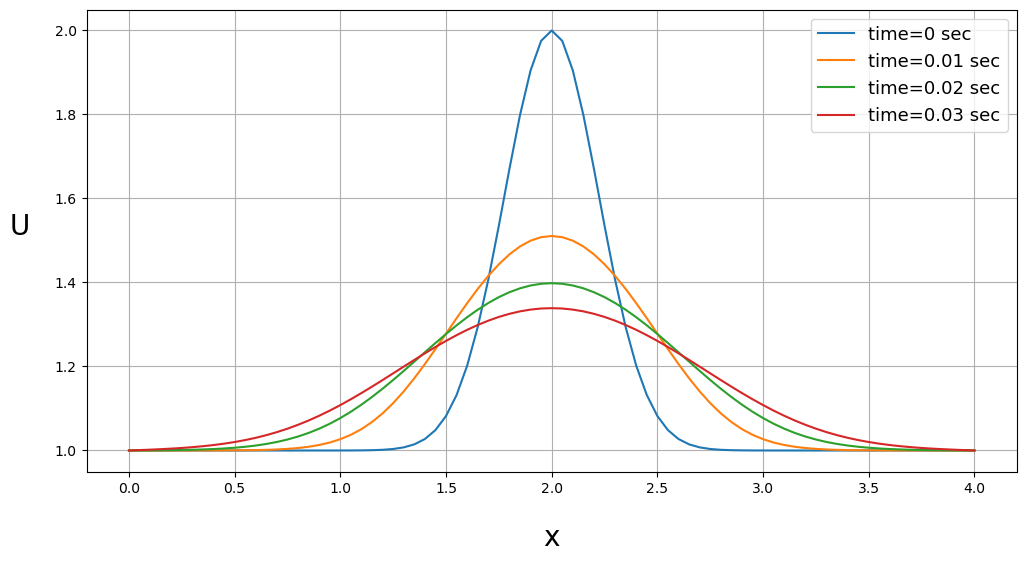

In [161]:
t0, t1, t2, t3 = 0, 0.01, 0.02, 0.03
i0, i1, i2, i3 = int(len(t)*t0), int(len(t)*t1), int(len(t)*t2), int(len(t)*t3)

plt.figure(figsize=(12, 6))
plt.plot(x, u[i0, :], label=f'time={t0} sec')
plt.plot(x, u[i1, :], label=f'time={t1} sec')
plt.plot(x, u[i2, :], label=f'time={t2} sec')
plt.plot(x, u[i3, :], label=f'time={t3} sec')
plt.xlabel('x', fontsize=20, labelpad=20)
plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
plt.legend(fontsize=13)
plt.grid()

In [145]:
@interact(t_moment=widgets.FloatSlider(value=0, min=0.0001, max=t[-1], step=tau))
def visualize(t_moment):
    
    index = int(len(t) * t_moment)

    plt.figure(figsize=(12, 6))
    plt.plot(x, u[index, :], label=f'time={t_moment} sec')
    plt.xlabel('x', fontsize=20, labelpad=20)
    plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
    plt.legend(fontsize=13)
    plt.grid()

interactive(children=(FloatSlider(value=0.0001, description='t_moment', max=0.9995850000000002, min=0.0001, st…

## --------------------------

## Implicit Scheme draft

Неявная схема для квазилинейного уравнения (стр 148)

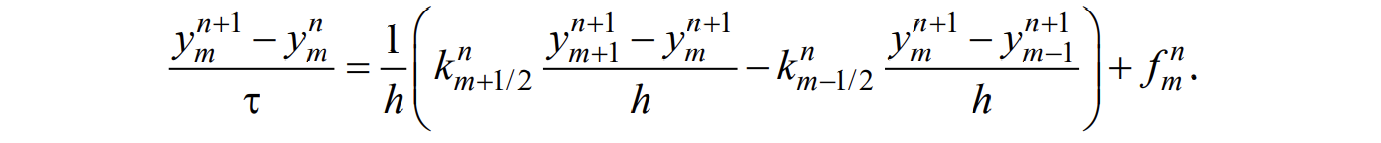

$$ k^{n}_{i+\frac{1}{2}} = \left(  \frac{k_i^n + k^n_{i+1}}{2} \right)$$

$$ k^{n}_{i-\frac{1}{2}} = \left(  \frac{k_i^n + k^n_{i-1}}{2} \right)$$

In [5]:
L = 4  # граница по координате
# L = 1
t_max = 1  # граница по времени

h = 1e-2  # шаг по координате 
tau = 1e-3  # шаг по времени

# k = 0.5  # g(x, t) = k * U^alpha
# alpha = 5

n_x = int(L / h) + 1
n_t = int(t_max / tau) + 1
u = np.zeros((n_t, n_x))

In [6]:
# Lambda = np.zeros((n_t, n_x))  # создается полностью заполненным

Q = np.zeros((n_t, n_x))  # создается полностью заполненным

In [7]:
# grid initialization
x = np.zeros(n_x)
t = np.zeros(n_t)

# grid x
for i in range(len(x)):
    x[i] = i * h
    
# grid t
for i in range(len(t)):
    t[i] = i * tau

In [52]:
def T_x_0(x):
    """Начальное условие T(x, 0)"""
    return 1 + np.exp((-(x-2)**2) / 0.1)
    # return np.sin(np.pi * x)

def T_0_t(t):
    """
    Граничное условие слева T(0, t)
    """
    return 1
    # return 0

def T_x_max_t(t):
    """
    Граничное условие справа T(x_max, t)
    """
    return 1
    # return 0  

    

In [4]:
def set_Lambda(u):
    """Штука под правым дифференциалом"""
    return 5 * u
    # return np.ones(u.shape)

In [187]:
u[0] = T_x_0(x)  # начальное условие


u[:, 0] = T_0_t(t)  # граничные условия слева

u[:, -1] = T_x_max_t(t)  # граничные условия справа
u

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [188]:
Lambda = set_Lambda(u)

Lambda.shape

(1001, 401)

In [189]:
for n in tqdm(range(0, n_t-1)):
    
    A = np.zeros(n_x)
    B = np.zeros(n_x)
    C = np.zeros(n_x)
    F = np.zeros(n_x)
    
    Lambda = set_Lambda(u)  # обязательно пересчитывать Lambda, если она зависит от u !!!!
    
    for i in range(1, n_x-1):
        A[i] = (1/(h**2)) * ((Lambda[n, i] + Lambda[n, i+1]) / 2)
        B[i] = (1/(h**2)) * ((Lambda[n, i] + Lambda[n, i-1]) / 2)
        C[i] = A[i] + B[i] + (1 / tau)
        
        F[i] = Q[n, i] + (u[n, i] / tau)
        
    A = A[1:]  # выкидываем ненужный
    A[-1] = 0  # дополнение граничными условиями
    
    C[0] = 1  # дополнение граничными условиями
    C[-1] = 1  # дополнение граничными условиями
    
    B[0] = 0  # дополнение граничными условиями
    B = B[:-1]  # выкидываем ненужный
    
    F[0] = T_0_t(t)  # граничные условия слева
    F[-1] = T_x_max_t(t)  # граничные условия справа
    
#     Matrix = tridiag(-A, C, -B)
#     u[n+1] = np.linalg.solve(Matrix, F)
    
    u[n+1] = progonka(-A, C, -B, F)
    


  0%|          | 0/1000 [00:00<?, ?it/s]

In [190]:
@interact(t_moment=widgets.FloatSlider(value=0, min=0.0001, max=t_max, step=tau))
def visualize(t_moment):
    
    index = int(len(t) * t_moment)

    plt.figure(figsize=(12, 6))
    plt.plot(x, u[index, :], label=f'time={t_moment} sec')
    plt.xlabel('x', fontsize=20, labelpad=20)
    plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
    plt.legend(fontsize=13)
    plt.grid()

interactive(children=(FloatSlider(value=0.0001, description='t_moment', max=1.0, min=0.0001, step=0.001), Outp…

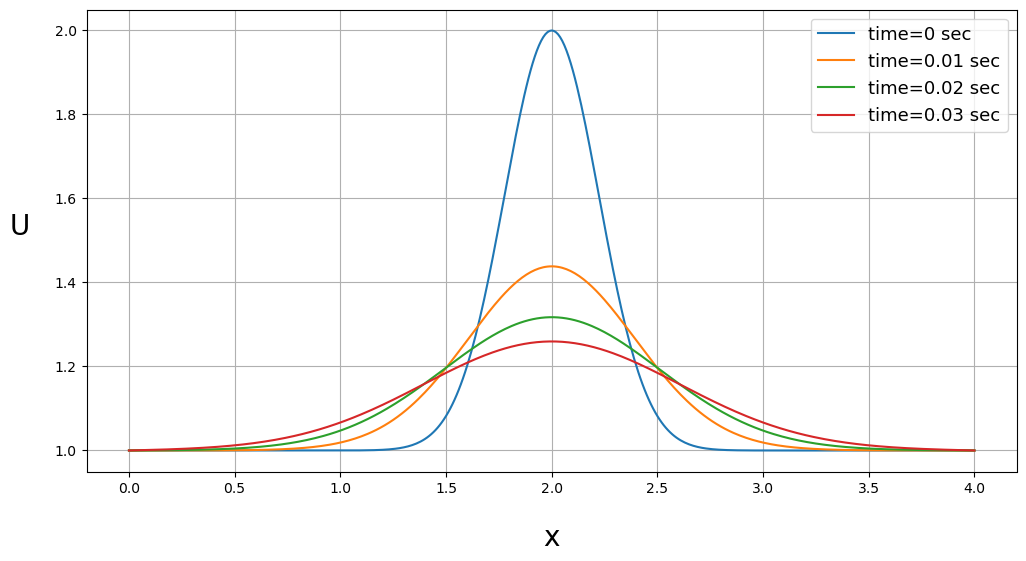

In [221]:
t0, t1, t2, t3 = 0, 0.01, 0.02, 0.03
i0, i1, i2, i3 = int(len(t)*t0), int(len(t)*t1), int(len(t)*t2), int(len(t)*t3)

plt.figure(figsize=(12, 6))
plt.plot(x, u[i0, :], label=f'time={t0} sec')
plt.plot(x, u[i1, :], label=f'time={t1} sec')
plt.plot(x, u[i2, :], label=f'time={t2} sec')
plt.plot(x, u[i3, :], label=f'time={t3} sec')
plt.xlabel('x', fontsize=20, labelpad=20)
plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
plt.legend(fontsize=13)
plt.grid()

## Explicit scheme draft

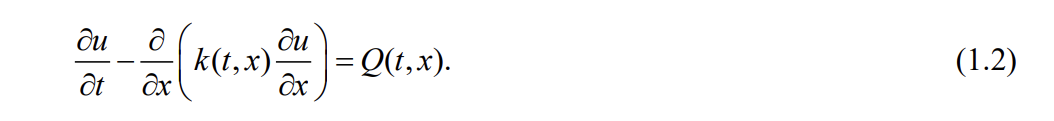

стр 142

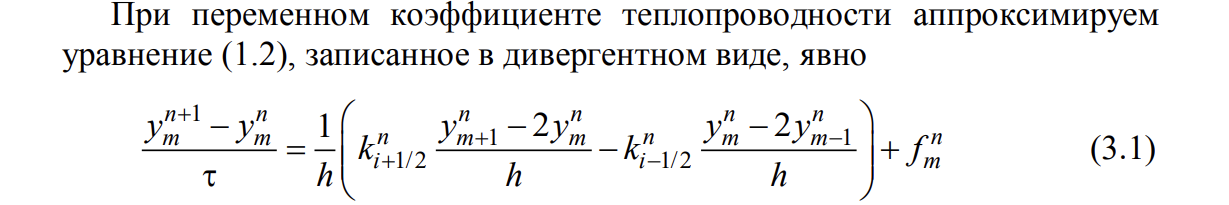

In [12]:
L = 4  # граница по координате
# L = 1
t_max = 1  # граница по времени

h = 5e-2  # шаг по координате 
# tau = 1e-3  # шаг по времени

tau = ((h**2 / 2) - 0.03 * (h**2 / 2)) / 10

n_x = int(L / h) + 1
n_t = int(t_max / tau) + 1
u = np.zeros((n_t, n_x))

Q = np.zeros((n_t, n_x))

In [13]:
# grid initialization
x = np.zeros(n_x)
t = np.zeros(n_t)

# grid x
for i in range(len(x)):
    x[i] = i * h
    
# grid t
for i in range(len(t)):
    t[i] = i * tau

In [14]:
factor = (tau / (h**2))

assert factor < 0.5, f'cfd = {factor}'

In [15]:
tau

0.00012125000000000002

In [16]:
u.shape

(8248, 81)

In [17]:
u[0] = T_x_0(x)  # начальное условие


u[:, 0] = T_0_t(t)  # граничные условия слева

u[:, -1] = T_x_max_t(t)  # граничные условия справа

In [19]:
# u

In [20]:
for n in tqdm(range(n_t-1)):
    
    Lambda = set_Lambda(u)
    
    for i in range(1, n_x-1):
        A = ((Lambda[n, i] + Lambda[n, i+1]) / 2) * (u[n, i+1] - u[n, i])
        B = ((Lambda[n, i] + Lambda[n, i-1]) / 2) * (u[n, i] - u[n, i-1])
        C = (tau / (h**2)) * (A - B)
                
        u[n+1, i] = u[n, i] + tau * Q[n, i] + C

  0%|          | 0/8247 [00:00<?, ?it/s]

In [21]:
@interact(t_moment=widgets.FloatSlider(value=0, min=0.0001, max=t[-1], step=tau))
def visualize(t_moment):
    
    index = int(len(t) * t_moment)

    plt.figure(figsize=(12, 6))
    plt.plot(x, u[index, :], label=f'time={t_moment} sec')
    plt.xlabel('x', fontsize=20, labelpad=20)
    plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
    plt.legend(fontsize=13)
    plt.grid()

interactive(children=(FloatSlider(value=0.0001, description='t_moment', max=0.9999487500000002, min=0.0001, st…

---


---



---

In [141]:
h = 0.025
# tau = 0.25

tau = (h**2 / 2) - 0.01 * (h**2 / 2)

x = np.arange(0, 1+h, h)
t = np.arange(0, 1+tau, tau)

n_x = len(x)
n_t = len(t)

u = np.zeros((n_t, n_x))

In [142]:
u[0] = T_x_0(x)  # начальное условие

u[:, 0] = T_0_t(t)  # граничные условия слева

u[:, -1] = T_x_max_t(t)  # граничные условия справа

In [143]:
tau

0.0003093750000000001

In [144]:
cfd = (tau / (h**2))

assert cfd < 0.5, f'cfd = {cfd}'

In [145]:
for n in tqdm(range(n_t-1)):

    for i in range(1, n_x-1):

        u[n+1, i] = cfd * u[n, i-1] + (1 - 2 * cfd) * u[n, i] + cfd * u[n, i+1]
        


  0%|          | 0/3233 [00:00<?, ?it/s]

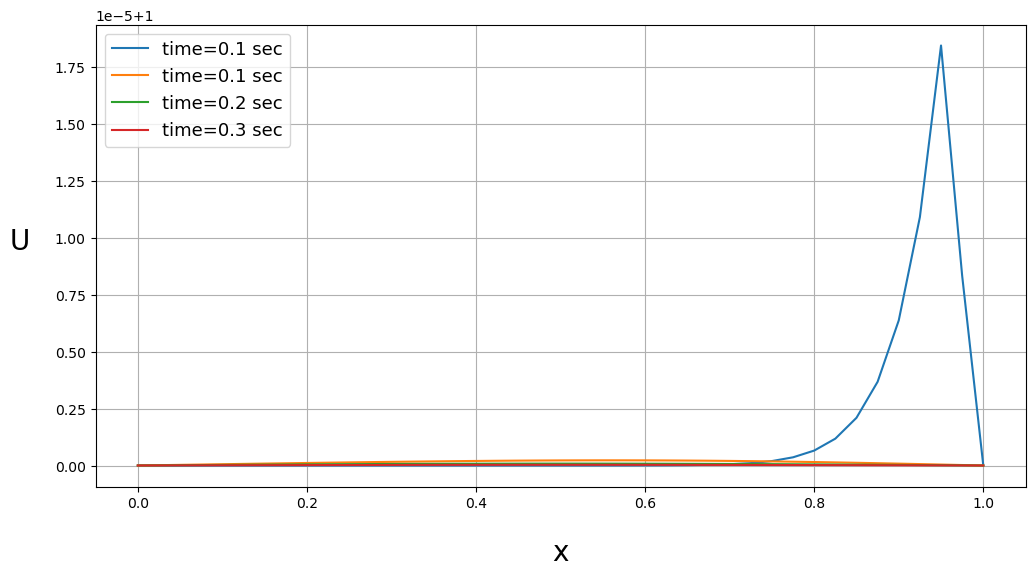

In [152]:
t0, t1, t2, t3 = t[1], 0.1, 0.2, 0.3
i0, i1, i2, i3 = int(len(t)*t[1]), int(len(t)*t1), int(len(t)*t2), int(len(t)*t3)

plt.figure(figsize=(12, 6))
plt.plot(x, u[i0, :], label=f'time={t1} sec')
plt.plot(x, u[i1, :], label=f'time={t1} sec')
plt.plot(x, u[i2, :], label=f'time={t2} sec')
plt.plot(x, u[i3, :], label=f'time={t3} sec')
plt.xlabel('x', fontsize=20, labelpad=20)
plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
plt.legend(fontsize=13)
plt.grid()

In [153]:
@interact(t_moment=widgets.FloatSlider(value=0, min=0.0001, max=t[-1], step=tau))
def visualize(t_moment):
    
    index = int(len(t) * t_moment)

    plt.figure(figsize=(12, 6))
    plt.plot(x, u[index, :], label=f'time={t_moment} sec')
    plt.xlabel('x', fontsize=20, labelpad=20)
    plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
    plt.legend(fontsize=13)
    plt.grid()

interactive(children=(FloatSlider(value=0.0001, description='t_moment', max=1.0002093750000003, min=0.0001, st…

In [27]:
for n in tqdm(range(n_t-1)):
    
    Lambda = set_Lambda(u)  # обязательно пересчитывать Lambda, если она зависит от u !!!!
    
    for i in range(1, n_x-1):
        # try:
        
        A1 = tau * (1/(h**2)) * ((Lambda[n, i] + Lambda[n, i+1]) / 2) 
        assert A1 == 10
        
        A2 = (u[n, i+1] - u[n, i])
        A = A1 * A2

        B1 = tau * (1/(h**2)) * ((Lambda[n, i] + Lambda[n, i-1]) / 2)
        assert B1 == 10
        
        B2 = (u[n, i] - u[n, i-1])
        B = B1 * B2
        # A = (1/(h**2)) * ((Lambda[n, i] + Lambda[n, i+1]) / 2) * (u[n, i+1] - 2*u[n, i])
        # B = (1/(h**2)) * ((Lambda[n, i] + Lambda[n, i-1]) / 2) * (u[n, i] - 2*u[n, i-1])
        C = tau * Q[n, i]
        assert C == 0
        # except RuntimeWarning:
        #     print(n, i)
        #     print(B1, B2, B)
        #     break
        
        # res = tau * (A - B + C) + u[n, i]
        res = A - B + C + u[n, i]
        
        u[n+1, i] = res
    
    


  0%|          | 0/33 [00:00<?, ?it/s]

AssertionError: 

In [56]:
# u[3]

In [130]:
@interact(t_moment=widgets.FloatSlider(value=0, min=0.0001, max=t_max, step=tau))
def visualize(t_moment):
    
    index = int(len(t) * t_moment)

    plt.figure(figsize=(12, 6))
    plt.plot(x, u[index, :], label=f'time={t_moment} sec')
    plt.xlabel('x', fontsize=20, labelpad=20)
    plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
    plt.legend(fontsize=13)
    plt.grid()

interactive(children=(FloatSlider(value=0.0001, description='t_moment', max=1.0, min=0.0001, step=0.001), Outp…

In [161]:
h = 0.25
tau = 0.25

x = np.arange(0, 1+h, h)
t = np.arange(0, 1+tau, tau)

n_x = len(x)
n_t = len(t)

u = np.zeros((n_x, n_t))

In [178]:
h = 1e-2
tau = 1e-2

x = np.arange(0, 1+h, h)
t = np.arange(0, 1+tau, tau)

n_x = len(x)
n_t = len(t)

u = np.zeros((n_x, n_t))

In [179]:
factor = (tau / (h**2))

In [180]:
u[0, :] = 0
u[-1, :] = 0

u[:, 0] = np.sin(np.pi * x) 

In [181]:
for n in range(1, n_t):
    for i in range(1, n_x-1):
        u[i, n] = factor * u[i-1, n-1] + (1 - 2*factor) * u[i, n-1] + factor * u[i+1, n-1]

In [182]:
u.round(3)

array([[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 3.10000000e-002,  2.80000000e-002,  2.60000000e-002, ...,
         1.25879091e+236, -4.59882348e+238,  1.66823384e+241],
       [ 6.30000000e-002,  5.70000000e-002,  5.10000000e-002, ...,
        -2.09382957e+236,  7.53067966e+238, -2.68079533e+241],
       ...,
       [ 6.30000000e-002,  5.70000000e-002,  5.10000000e-002, ...,
         1.66598919e+238, -6.62412951e+240,  2.63387214e+243],
       [ 3.10000000e-002,  2.80000000e-002,  2.60000000e-002, ...,
        -8.38905687e+237,  3.33541151e+240, -1.32615984e+243],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

In [183]:
u = u.T

In [184]:
@interact(t_moment=widgets.FloatSlider(value=0, min=0.0001, max=1, step=tau))
def visualize(t_moment):
    
    index = int(len(t) * t_moment)

    plt.figure(figsize=(12, 6))
    plt.plot(x, u[index, :], label=f'time={t_moment} sec')
    plt.xlabel('x', fontsize=20, labelpad=20)
    plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
    plt.legend(fontsize=13)
    plt.grid()

interactive(children=(FloatSlider(value=0.0001, description='t_moment', max=1.0, min=0.0001, step=0.01), Outpu…

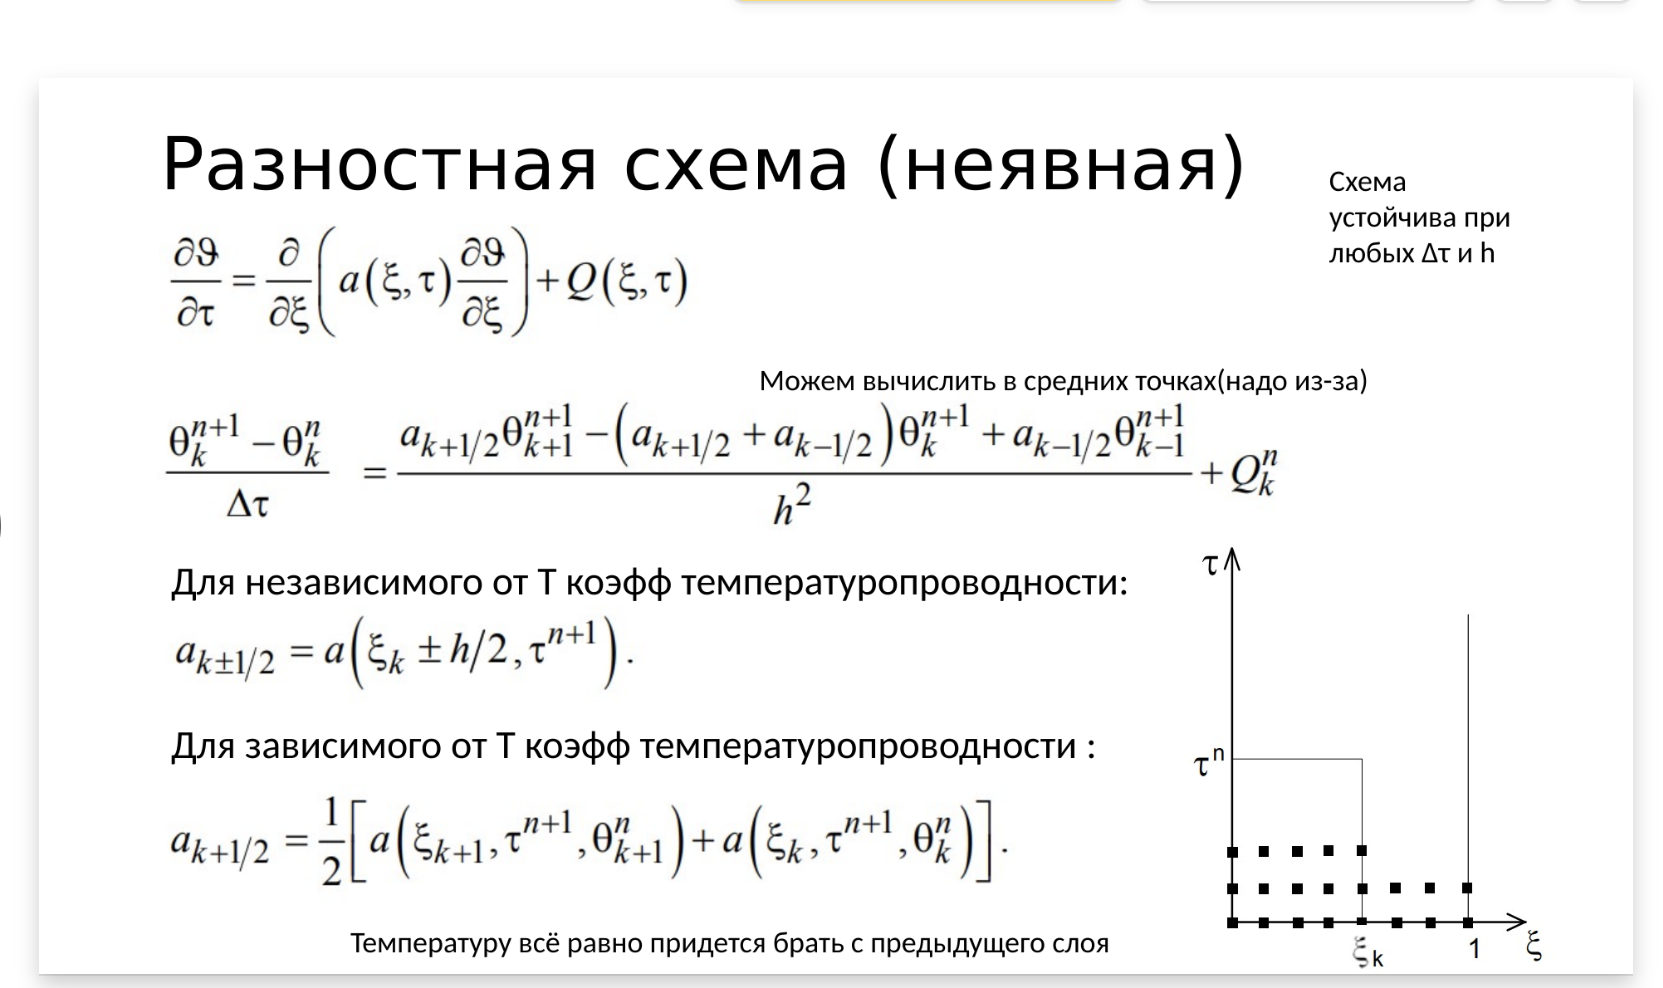

**Нелинейная схема**

In [12]:
L = 4
t_max = 1

h = 1e-2
tau = 1e-3

k = 0.5  
alpha = 4

n_x = int(L / h) + 1
n_t = int(t_max / tau) + 1
u1 = np.zeros((n_t, n_x))

In [13]:
# начальные условия
u1[0] = T(x)
# граничные условия
u1[:, 0] = 1
u1[:, -1] = 1
u1

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [14]:
P = np.zeros((n_t, n_x))
Q = np.zeros((n_t, n_x))
# P[1] = c[0] / b[0]
# Q[1] = -d[0] / b[0]
P[:, 1] = 0  
Q[:, 1] = 1


for i in range(1, n_t):
    for j in range(1, n_x-1):        
        A = (((u1[i-1, j] + u1[i-1, j-1]) / 2)**alpha) * (k / (0.5*(dx[j]+dx[j-1])*dx[j-1]))
        B = (((u1[i-1, j] + u1[i-1, j+1]) / 2)**alpha) * (k / (0.5*(dx[j]+dx[j-1])*dx[j]))
        C = A + B + (1 / tau)
        F = u1[i-1, j] / tau

        P[i, j+1] = B / (C - A*P[i, j])
        Q[i, j+1] = (A*Q[i, j] + F) / (C - A*P[i, j])
        
    for j in range(n_x-1, 0, -1):
        u1[i, j-1] = P[i, j] * u1[i, j] + Q[i, j]
        

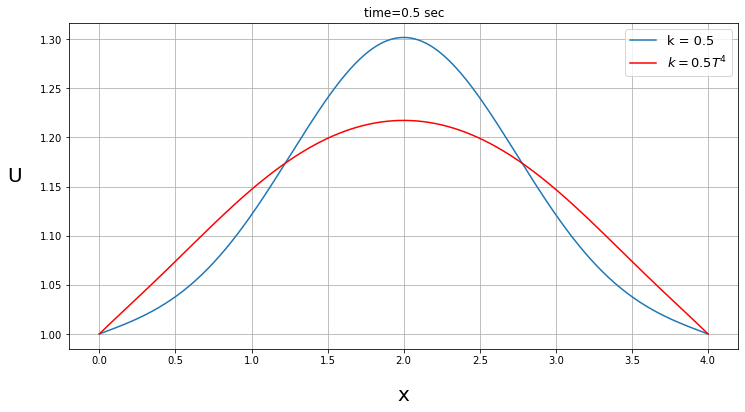

In [15]:
t1 = 0.5
i1 = int(len(t)*t1)

plt.figure(figsize=(12, 6))
plt.plot(x, u[i1, :], label='k = 0.5')
plt.plot(x, u1[i1, :], label=fr'$k = 0.5 T^{alpha}$', color='r')

plt.xlabel('x', fontsize=20, labelpad=20)
plt.ylabel('U', fontsize=20, rotation='horizontal', labelpad=25)
plt.title(f'time={t1} sec')
plt.legend(fontsize=13)
plt.grid()

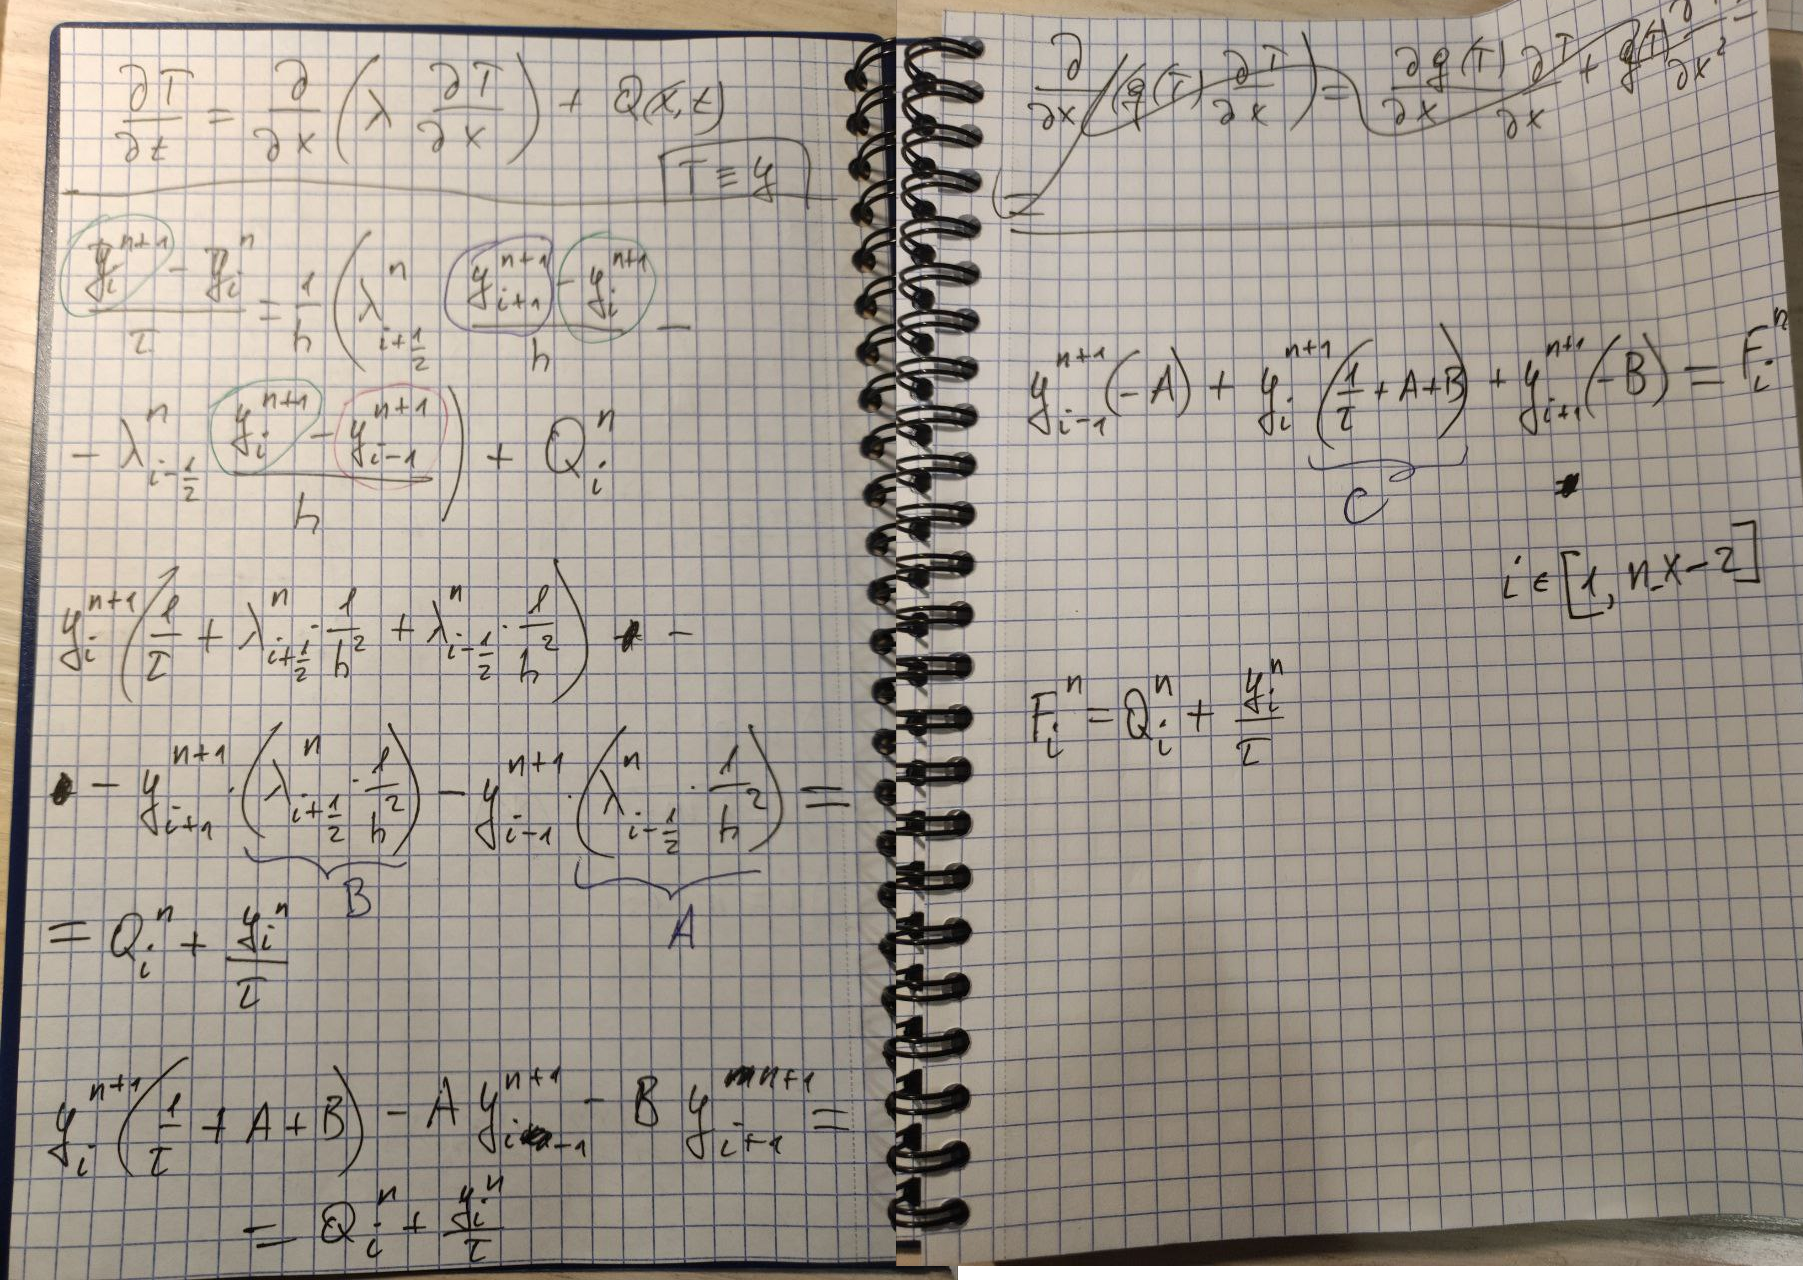

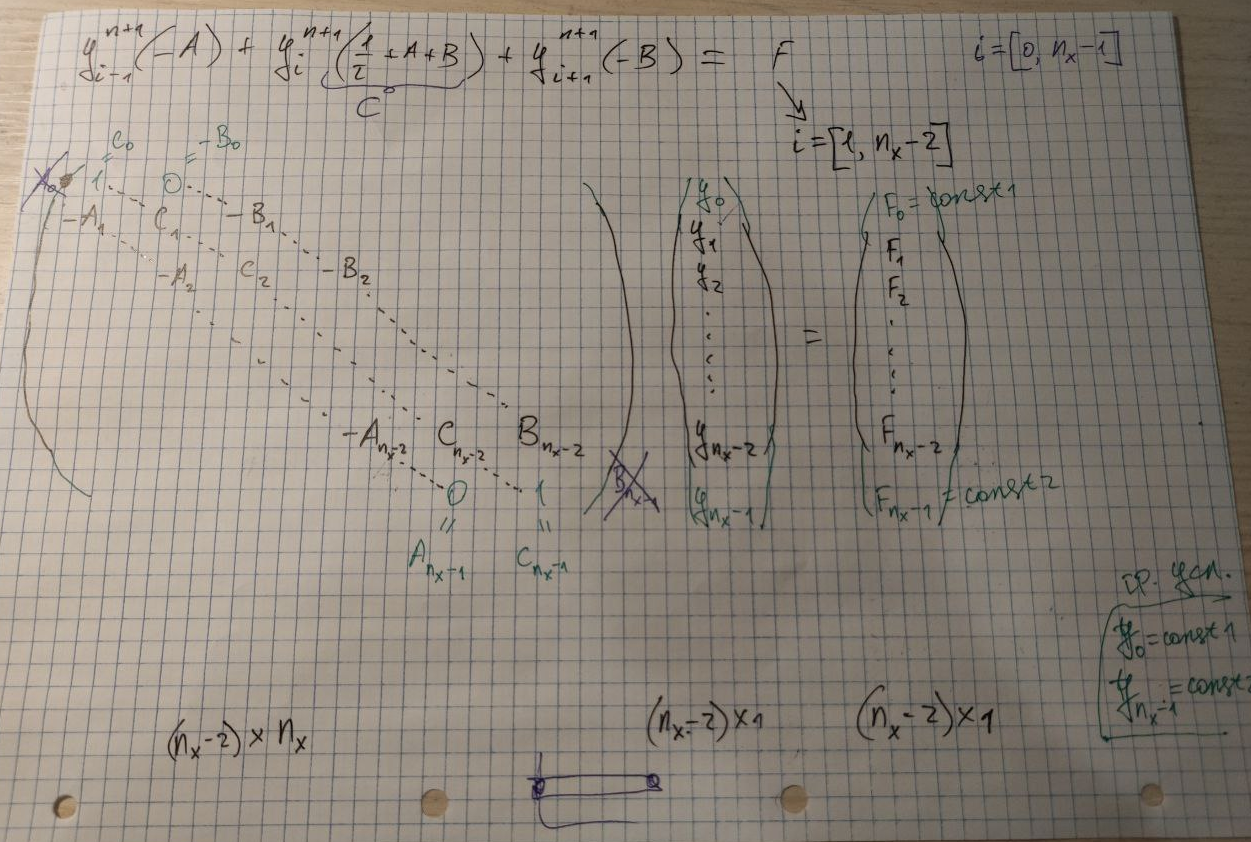